# Estimate virality of a tweet 

In this notebook we estimate a proxy for how popular a tweet is across two geographical dimensions: the local dimension (i.e. either just Nottingham or Liverpool) or the overall dimension (i.e. regardless of location).

- **Local Virality.** Since our sample is defined by the location of our users, we can estimate how popular a tweet is locally by how many times the tweet appears in the sample. The rationale is that, if a tweet is quoted or retweeted many times by someone in the same area, then it will appear a lot of times in our sample. Our local virality estimator will be a count of the times a tweet appears in our sample. 

- **Overall Virality.** Meltwater provides a variable called "Engagement", which is defined as the total number of times that a person has interacted with a tweet. Meltwater monitors each tweet's engagement for its first 12 hours of life. In other words, we can see how many times people interacted with the tweet up until 12 hours after its publication. Interactions include clicks on the tweet, media or the profile of the author among others. After isolating tweets (i.e. removing "RT/QT tags", QT comments, etc, for each entry of our dataset), we can estimate overall virality by adding up the number of interactions that the tweet had across its multiple retweets/quotes. Only interactions attributed to the person retweeting or quoting retweet are measured. In other words, if @user1 retweets a tweet by @realDonaldTrump, we will only see in our sample the interactions with @realDonaldTrump's tweet that happened _because of_ @user1's retweet. Albeit limited, since these interactions are not restricted to people from the local area where we are downloading the tweets from, we can get an idea of how popular a tweet can become _both inside and outside of_ Nottingham.

For data protection purposes, the dataset used in this notebook is not provided here. If you want to replicate the notebook using this dataset, please contact the authors.

#### Input
- Processed data: `Meltwater_processed.csv`

#### Output
- A dataset with one tweet per line, which includes our virality indicators: `tweets_virality.csv`

### 1. Preliminaries

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df_proc = pd.read_csv('/project_data/data_asset/Meltwater_processed.csv')
print('Shape of data:', df_proc.shape)
df_proc.head()


### 2. Identify popular tweets

In [3]:
# Let's eyeball first most popular tweets
df_proc.groupby('Text_comment').agg({'Influencer':'count'}).sort_values(by = 'Influencer', ascending = False).head(15) # Same as value_counts, but visualisation is better like this

In [4]:
# Dataframe with one tweet per line
df_tweets = df_proc.groupby(['Text_comment', 'City'], as_index = False).agg({'Influencer':'count', 'Engagement':'sum'})
df_tweets.rename(columns = {'Influencer':'Local Virality', 'Engagement':'Overall Virality'}, inplace = True)

df_tweets.sort_values(by='Local Virality', ascending = False).head(10)

In [5]:
# Split df by city
tweets_notts = df_tweets[df_tweets['City'] == 'Nottingham'].copy()
tweets_liv = df_tweets[df_tweets['City'] == 'Liverpool'].copy()

### 3. Visualisation



The nature of the virality measures is that they are not exactly made of the same components, so they are not immediately comparable. A good way to (partially) overcome this issue is to scale the data. This also helps us compare between cities, since by definition more populated cities will have more tweets and hence virality scores will be higher there. 

The choice of the scaling procedure is not trivial. Below we try Scikit-Learn's `StandardScaler`, `MinMaxScaler` and `RobustScaler`. Alternatively, we can also take the logarithm of the indicators (although we'd have to deal with zeros somehow). All of them have pros and cons.

- `StandardScaler`. Subtracts the mean and sets variance to 1. This makes identification of outliers relatively easy if we want to use a threshold (say, all scores > 3). This scaling procedure is generally recommended when data is normally distributed, but ours follows a power law. 
- `MinMaxScaler`. Condenses all datapoints between 0 and 1 (or another specified interval). This is great for visualisation and explainability, but it's heavily dependent on outliers. Therefore, it's difficult to set thresholds to identify popular tweets.
- `RobutsScaler`. Subtracts the median, rather than the mean, from each data point. Not necessarily for normally distributed data, so it overcomes this issue from `StandardScaler`. It makes visualising outliers (popular tweets) easier. However, it's more difficult to interpret and it's not clear where to put a threshold for classification.

In [62]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()

tweets_notts['Local Virality_std'] = scaler.fit_transform(tweets_notts['Local Virality'].values.reshape(-1, 1))
tweets_notts['Overall Virality_std'] = scaler.fit_transform(tweets_notts['Overall Virality'].values.reshape(-1, 1))

tweets_liv['Local Virality_std'] = scaler.fit_transform(tweets_liv['Local Virality'].values.reshape(-1, 1))
tweets_liv['Overall Virality_std'] = scaler.fit_transform(tweets_liv['Overall Virality'].values.reshape(-1, 1))

df_tweets_std = tweets_liv.append(tweets_notts)


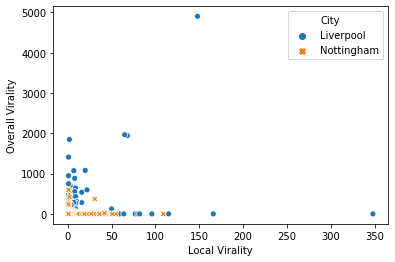

In [64]:
sns.scatterplot(data=df_tweets_std, x="Local Virality", y="Overall Virality", hue="City", style = 'City')
plt.show()

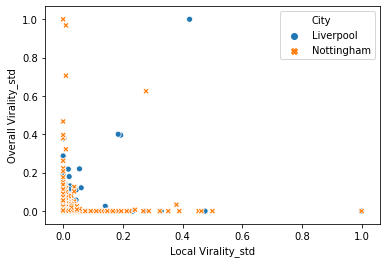

In [65]:
sns.scatterplot(data=df_tweets_std, x="Local Virality_std", y="Overall Virality_std", hue="City", style = 'City')
plt.show()

In [6]:
len(df_tweets)

In [68]:
# Export
df_tweets.to_csv('/project_data/data_asset/tweets_virality.csv', index = False)

_________

#### Author
- **Álvaro Corrales Cano** is a Data Scientist within IBM's Cloud Pak Acceleration team. With a background in Economics, Álvaro specialises in a wide array Econometric techniques and causal inference, including regression, discrete choice models, time series and duration analysis.

Copyright © IBM Corp. 2020. Licensed under the Apache License, Version 2.0. Released as licensed Sample Materials.
